In [1]:
#You may need to install these dependencies first, and then restart the kernel.
%pip install numpy==1.24.1
%pip install opencv-python
%pip install torch
%pip install matplotlib

from matplotlib import animation
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import os, cv2, numpy as np
from modular_nca import config, hex_renderer, hex_neural_model, hex_dataset

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# Select an epoch from 'training_checkpoints' to evaluate.
# If left as None, the latest will be used
eval_epoch_num = 4464 #None

In [3]:
# Setup

render_size = (400, 400)

model = hex_neural_model.HexNeuralModel(num_hidden_layers=12, nn_hidden_layer_sizes=(96, ), divisions=110)
renderer = hex_renderer.HexRenderer(render_size, model)
dataset = hex_dataset.HexDataset(model)

source_image = cv2.imread(config.dataset_dir + config.dataset_name + "-source.png")
source_image = cv2.resize(source_image, render_size)
source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)

print("Loading dataset: '%s'." %config.dataset_name)
dataset.load_time_series(config.dataset_path, start=0, end=1, stride=1, blur_strength=0.012)

if eval_epoch_num is None:
	eval_epoch_num = sorted([int(f.split("-")[-1].split(".")[0]) for f in os.listdir(config.checkpoint_dir)])[-1]

print("Loading pre-trained model from epoch %d." %eval_epoch_num)
model.load_nn(eval_epoch_num)

model.set_mask(dataset.masks[0])

Loading dataset: 'leaf-mono-small'.
Created 2 time series samples from dataset path training_datasets/leaf-mono-small/.
Loading pre-trained model from epoch 4464.


c:\Users\Alex\Desktop\Git Repos\modular-nca\modular_nca\hex_neural_model.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.nn.load_state_dict(torch.load(checkpoint_d

In [4]:
def make_preview_image(title="", show_hidden=False, show_source=False):
	mode = 0 if not show_hidden else int((model.num_layers-4)/3 + 3)
	result = renderer.update(mode)

	result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # OpenCV operates with BGR format

	if show_source:
		result = np.hstack((source_image, result))

	return title, result

def show_preview(preview):
	title, image = preview
	plt.title(title)
	plt.axis("off")
	plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
	plt.imshow(image)

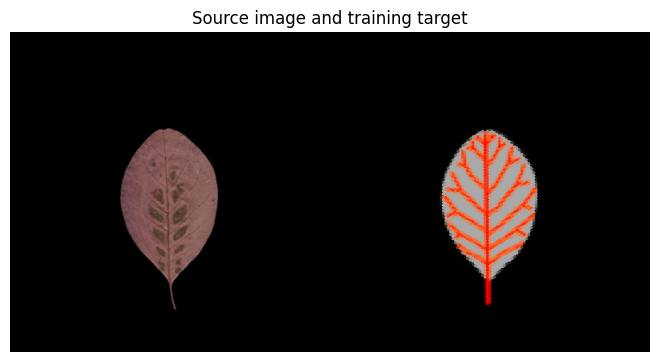

In [5]:
# Display target image

model.reset_grid_seed(dataset.samples[-1])
preview = make_preview_image("Source image and training target", show_source=True)
show_preview(preview)

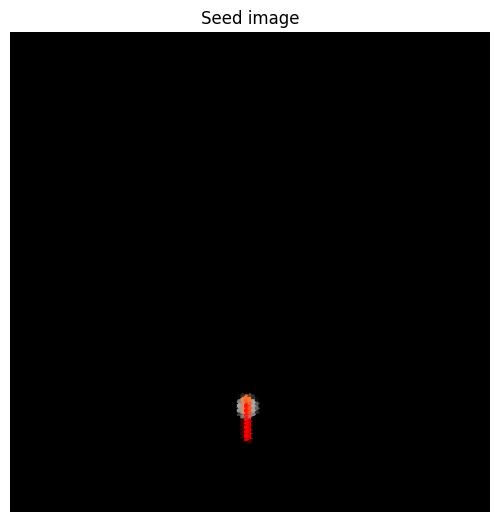

In [6]:
# Display seed image, the simulation starting point

model.reset_grid_seed(dataset.samples[0])
preview = make_preview_image(title="Seed image")
show_preview(preview)

In [7]:
# Run simulation for 500 steps
model.reset_grid_seed(dataset.samples[0])
step_count = 500
preview_interval = 10

intermediate_results = []
for i in range(step_count+1):
	model.step()

	if (i % preview_interval) == 0:
		print("Running step %d/%d" %(i, step_count))
		preview = make_preview_image(title="Simulation state after %d steps" %i, show_hidden=True)
		intermediate_results.append(preview)

print("Simulation completed.")

Running step 0/500
Running step 10/500
Running step 20/500
Running step 30/500
Running step 40/500
Running step 50/500
Running step 60/500
Running step 70/500
Running step 80/500
Running step 90/500
Running step 100/500
Running step 110/500
Running step 120/500
Running step 130/500
Running step 140/500
Running step 150/500
Running step 160/500
Running step 170/500
Running step 180/500
Running step 190/500
Running step 200/500
Running step 210/500
Running step 220/500
Running step 230/500
Running step 240/500
Running step 250/500
Running step 260/500
Running step 270/500
Running step 280/500
Running step 290/500
Running step 300/500
Running step 310/500
Running step 320/500
Running step 330/500
Running step 340/500
Running step 350/500
Running step 360/500
Running step 370/500
Running step 380/500
Running step 390/500
Running step 400/500
Running step 410/500
Running step 420/500
Running step 430/500
Running step 440/500
Running step 450/500
Running step 460/500
Running step 470/500
Run

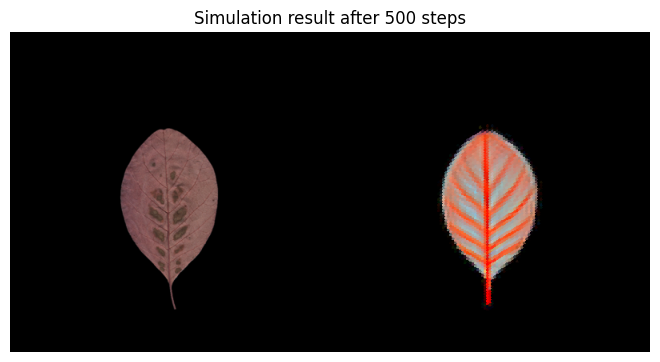

In [8]:
preview = make_preview_image(title="Simulation result after %d steps" %step_count, show_hidden=False, show_source=True)
show_preview(preview)

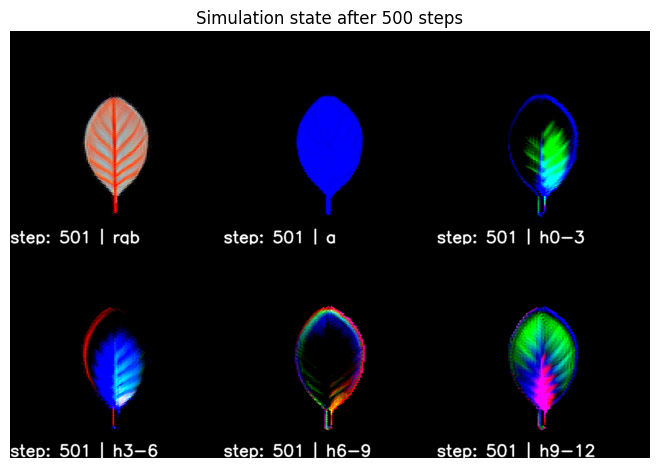

In [9]:
def make_video_preview(sequence):
	# Adapted from: https://gist.github.com/foolishflyfox/e30fd8bfbb6a9cee9b1a1fa6144b209c

	title, image = sequence[0]
	fig = plt.figure(facecolor="none")

	plt.title(title)
	plt.axis("off")
	plt.subplots_adjust(left=0, right=1, top=0.9, bottom=0)

	def animate(i):
		title, image = sequence[i]
		plt.title(title)
		frame = plt.imshow(image)
		return (frame,)

	result = animation.FuncAnimation(fig, animate, frames=len(sequence), interval=150, repeat_delay=1, repeat=True)
	display(HTML(result.to_html5_video()))
	
make_video_preview(intermediate_results)